# Finetuning with Trainer/Validation of saved models/Prompting wth OpenAI-like API
This notebook is used for development of few tasks: 
- finetuning of text classifiation models
- validating saved models
- communicating with OpenAI-like API

They will be divided into separate notebooks, but as for now it's more convenient to keep them here, while common part of their pipelines are changed almost each commit. 

data source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx

In [11]:
# set run environment (local/colab)
# if colab install required packages and set appropriate root_path
import os

if os.getenv("COLAB_RELEASE_TAG"):
    colab = True
    !pip install transformers[torch]
    !pip install accelerate -U
    !pip install datasets
    !pip install torchinfo
    #ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = '/content/drive/Othercomputers/My computer/EQILLM/'
else:
    colab = False
    root_path = ''


import itertools
import pandas as pd
import openai
import datetime
import os
import csv

from dotenv import load_dotenv, dotenv_values
from tqdm.notebook import tqdm_notebook
from eqillm import finetune, get_log_for_val, validate, val_metrics, yeelight_eow_notification, add_root, param_combinations, load_PolarIs, df_to_ds


dotenv_config = dotenv_values('.env')
yeelight_notify = dotenv_config['YEELIGHT_NOTIFY'] if 'YEELIGHT_NOTIFY' in dotenv_config else False

## Validate

acc: 0.7346153846153847
f1: 0.5655779668969911


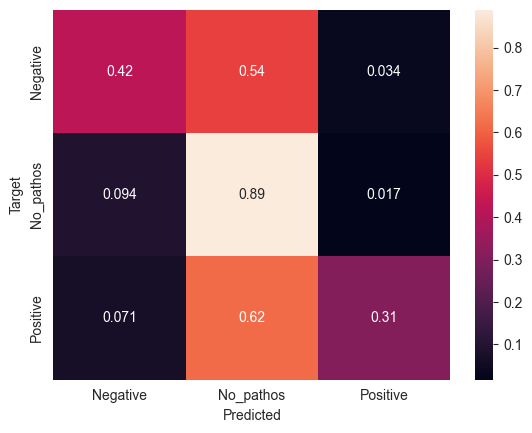

In [9]:
# Load PolarIs-Pathos to df
# source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx
data_path = os.path.join(root_path, 'data/PolarIs-Pathos.xlsx')
checkpoint_path = 'output/models/michellejieli/emotion_text_classifier_2024-04-14_23-58/checkpoints/checkpoint-5262'

val_row = get_log_for_val(checkpoint_path, os.path.join(root_path, 'output/training_logs.csv'))
val_row['split'] = tuple([float(i) for i in val_row['split'][1:-1].split(', ')])
val_row['model_path'] = os.path.join(root_path, val_row['model_path'])

dataset, target_map, reversed_target_map = csv_to_ds(data_path, val_row['binary'], val_row['split'])
predicted_labels, true_labels = validate(val_row, dataset)
val_metrics(predicted_labels, true_labels, target_map)

# Prompting

In [15]:
prompts = pd.read_csv('output/prompting/prompt_log.csv', encoding='cp1252')
all_messages = prompts.groupby(['system', 'user', 'assistant']).all()
system_and_assistant = [[i[0],i[1]] for i in all_messages.index]
for system, assistant in system_and_assistant:
    print(assistant)

# list(set([i[1] for i in sen_lab]))

import random
sen_lab = list(zip(dataset['train']['sentence'], [reversed_target_map[i] for i in dataset['train']['label']]))
path_examples = random.sample([i for i in sen_lab if i[1]=='Pathos'], 10)
nopath_examples = random.sample([i for i in sen_lab if i[1]=='No_pathos'], 10)
# print(*path_examples, sep='\n')
# print(*path_examples, sep='\n')
# 
# for x, y in list(zip(path_examples, nopath_examples)):
#     print(f'{x[0]} -> {x[1]}')
#     print(f'{y[0]} -> {y[1]}')
#     print('\n\n\n')    
system_and_assistant[0][1]

{'role': 'user', 'content': 'Analyze the following text for pathos: _'}
{'role': 'user', 'content': 'Analyze the following text for pathos: _'}
{'role': 'user', 'content': 'Analyze the following text for pathos: _'}
{'role': 'user', 'content': 'Analyze the following text for pathos: _'}
{'role': 'user', 'content': 'Analyze the following text for pathos: _'}
{'role': 'user', 'content': 'Analyze the following text for pathos: _'}


"{'role': 'user', 'content': 'Analyze the following text for pathos: _'}"

In [21]:
# Load PolarIs-Pathos to df
# source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx
data_path = os.path.join(root_path, 'data/PolarIs-Pathos.xlsx')
dataset, target_map, reversed_target_map = csv_to_ds(data_path, binary=False, split=(0.7, 0.1, 0.2), balanced=True)
val_txts, val_labels = dataset['train']['sentence'], dataset['train']['label']

# df = pd.read_excel(data_path)
# df['label'] = df[['No_pathos', 'Positive', 'Negative']].idxmax(axis=1)
# val_txts, val_labels = df['Sentence'], df['label']
# val_labels = val_labels.apply(lambda x: to_binary_classification(x))

C:\Users\Jakub\DataspellProjects\EQILLM\eqillm.py:125: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_test = [pd.concat([i[0], i[1]], axis=0) for i in zip(train_test, train_test_group)]


In [22]:
def create_messages(text='_'):
    return [
        {
            'role': 'system', 
             'content': "You are an analytical tool designed on identifying and categorizing pathos within messages. Pathos is an appeal made to an audience’s emotions in order to evoke feeling. The goal is to annotate whether or not each given text unit contains pathos, and if so, determine whether it appeals to positive, negative, or text doesn't contain pathos. Use your understanding of general cultural knowledge and linguistic cues present in the language to make accurate assessments. Things to take under consideration, but your response mustn't answer to any of those explicitly: 1. can you provide examples of how linguistic cues may indicate positive or negative emotions in a text unit? 2. How should annotators handle cases where it's ambiguous if a statement elicits any emotional response, and is there a need to consider context in these instances? 3. In the case of mixed pathos emotions, how should annotators prioritize identifying the dominant emotion when annotating? 4. How might sarcasm or irony affect the emotional interpretation and subsequent annotations within social media conversations?\n            \n            Note, the only responses to consider are: 'positive pathos', 'negative pathos' or 'no pathos'. If the intention is ambiguous, respond with 'unclear'. Respond in short manner, with only one of: 'positive pathos', 'negative pathos', 'no pathos', 'unclear'.\n                       \n            Examples (text -> response):\n            'Forget the looks, sheï¿½s a freaking liar, fraud, sociopath non-MD!' -> 'negative pathos'\n            'I honestly don't understand why this tech has not expanded to ubiquitous use.' -> 'no pathos'\n            'I made $5 an hour driving a tractor at age 12 in South Dakota' -> 'positive pathos'\n            "
        },
        {
            "role": "user",
            "content": f"""Analyze the following text for pathos: {text}"""
        },
        {
            "role": "assistant",
            "content": "Identify text with one of: 'Pathos', 'No_pathos'. Do not identify anything not listed."
        }
    ]

In [23]:
def looped_prompt(texts, labels, model_url=dotenv_config['MODEL_URL'], api_key=dotenv_config['MODEL_API_KEY']):
    client = openai.OpenAI(base_url=model_url,  api_key=api_key)
    model_name = client.models.list().data[0].dict()['id']

    prompt_log_path = os.path.join(root_path, 'output', 'prompting', 'prompt_log.csv')
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    response_log_path = os.path.join(root_path, 'output', 'prompting', 'responses', f'{timestamp}.csv')

    with open(prompt_log_path, mode='a+', newline='') as csv_file:
        writer = csv.writer(csv_file)
    if not os.path.exists(prompt_log_path):
        writer.writerow(['model', 'timestamp', 'message_system', 'message_user', 'message_assistant'])
        writer.writerow([model_name, timestamp, *create_messages()])

    with open(response_log_path, mode='a+', newline='', encoding="utf-8") as csv_file:
        writer = csv.writer(csv_file,  delimiter='|')
        writer.writerow(['sentence', 'label', 'timestamp', 'response'])
    
        for i, (txt, label) in tqdm_notebook(enumerate(zip(texts, labels))): # iterate through each text value of first df column
            completion = client.chat.completions.create(
                model="local-model", # this field is currently unused
                messages=create_messages(txt),
                temperature=0.7,
                max_tokens=20
            )
            writer.writerow([txt, label, timestamp, completion.choices[0].message.content])


looped_prompt(val_txts, val_labels)
yeelight_eow_notification()

0it [00:00, ?it/s]

In [2]:
# data_path = os.path.join(root_path, 'data/PolarIs-Pathos.xlsx')
# dataset, target_map, reversed_target_map = csv_to_ds(data_path, binary=True, split=(0.9, 0.1), balanced=True)
# val_txts, val_labels = dataset['train']['sentence'], dataset['train']['label']

C:\Users\Jakub\DataspellProjects\EQILLM\eqillm.py:125: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_test = [pd.concat([i[0], i[1]], axis=0) for i in zip(train_test, train_test_group)]
